# Statistics on missing CA and CB atoms AND side chain orientation angles

## Aims of this notebook

### 1. Missing CA and CB atoms

In our fingerprint, both the exposure and side chain orientation features are dependent on CA and CB atoms.
Here, we investigate where and overall how often these atoms are missing in the KLIFS data.

1. Get for each KLIFS molecule CA and CB atom coordinates per residue position.
2. Calculate missing atom rate per residue position: CA, CB and CA+CB missing.

### 2. Side chain orientation (SCO) distribution

SCO shall describe (as the name says) the orientation of a side chain. We need to make sure that the SCO is not an additional measure of size (we have that already in our fingerprint) but can truly show different orientations of a specific amino acid. 

Small amino acids (with tiny side chains) should not show much angle diversion (with smaller angles), larger ones should (with larger angles).

1. Calculate for each amino acid the angle distribution.
2. Save molecule and residue code for each angle, in order to trace back interesting angles.
3. Check diversity of angles per amino acid. If no diversity observed, side chain orientation might not be such a good measure, since it does not depend on structural conformation but solely on amino acid type.

## Imports

In [1]:
from pathlib import Path
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.extend(['./..'])

from kinsim_structure.auxiliary import KlifsMoleculeLoader
from kinsim_structure.encoding import SideChainOrientationFeature
from kinsim_structure.analysis import ResidueConservation, GapRate, SideChainOrientationStatistics

sns.set()
%matplotlib inline

## IO paths

In [2]:
path_to_data = Path('/') / 'home' / 'dominique' / 'Documents' / 'data' / 'kinsim' / '20190724_full'
path_to_kinsim = Path('/') / 'home' / 'dominique' / 'Documents' / 'projects' / 'kinsim_structure'
path_to_results = path_to_kinsim / 'results'

metadata_path = path_to_data / 'preprocessed' / 'klifs_metadata_preprocessed.csv'

## Load KLIFS metadata

In [3]:
klifs_metadata = pd.read_csv(metadata_path)

In [4]:
klifs_metadata.shape

(3920, 23)

In [5]:
klifs_metadata.head()

,Unnamed: 0,index,kinase,family,groups,pdb_id,chain,alternate_model,species,ligand_orthosteric_name,...,dfg,ac_helix,rmsd1,rmsd2,qualityscore,pocket,resolution,missing_residues,missing_atoms,full_ifp
0,0,2886,AAK1,NAK,Other,4wsq,B,A,Human,K-252A,...,in,in,0.777,2.125,8.6,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.95,0,14,0000000000000010000001000000000000000000000000...
1,1,10043,AAK1,NAK,Other,5l4q,A,A,Human,"~{N}-[5-(4-cyanophenyl)-1~{H}-pyrrolo[2,3-b]py...",...,in,in,0.780,2.137,9.7,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.97,0,3,0000000000000010000000000000000000000000000000...
2,2,7046,AAK1,NAK,Other,5te0,A,-,Human,methyl (3Z)-3-{[(4-{methyl[(4-methylpiperazin-...,...,in,in,0.776,2.120,8.8,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.90,0,12,1000101000000010000001000000000000000000000000...
3,3,843,ABL1,Abl,TK,2f4j,A,-,Human,CYCLOPROPANECARBOXYLIC ACID {4-[4-(4-METHYL-PI...,...,in,in,0.779,2.128,8.0,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,1.91,0,0,0000000000000010000001000000000000000000000000...
4,4,815,ABL1,Abl,TK,2g1t,A,-,Human,-,...,in,out,0.825,2.154,8.0,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,1.80,0,0,NaN


## Data generation

In [6]:
gap_rate = GapRate(klifs_metadata)

In [7]:
#sco_stats = SideChainOrientationStats()
#sco_stats.from_metadata(klifs_metadata)
#sco_stats.to_file(path_to_results)

## Gap rate

In [8]:
gap_rate.data.iloc[40:55]

,klifs_id,gaps,gap_rate
klifs_id,,,
41,41,6,0.0015
42,42,6,0.0015
43,43,4,0.0010
44,44,2,0.0005
45,45,2,0.0005
46,46,3,0.0008
47,47,6,0.0015
48,48,2,0.0005
49,49,10,0.0026


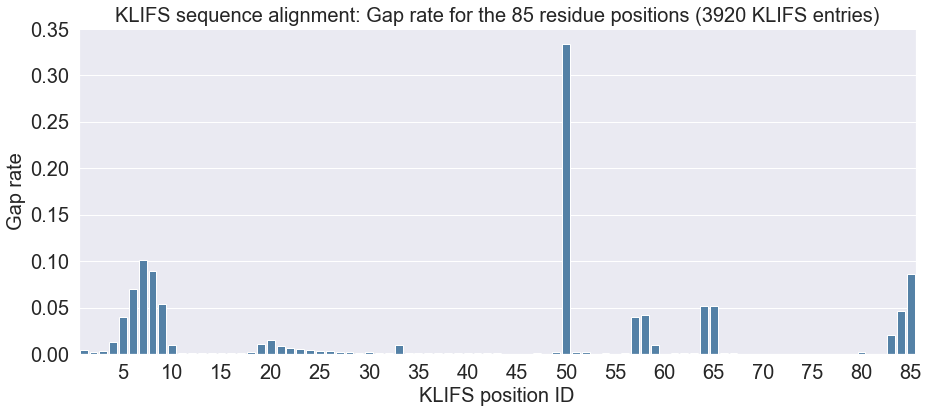

In [9]:
gap_rate.plot_gap_rate(path_to_results)

## Missing CA and CB atoms

In [10]:
sco_stats = SideChainOrientationStatistics(klifs_metadata)
sco_stats.from_file(path_to_results)

In [11]:
sco_stats.data

,klifs_id,residue_id,residue_name,ca,cb,com,sco,klifs_code
0,1,50,GLU,"<Vector -3.20, -23.46, -71.05>","<Vector -2.63, -22.05, -70.79>","<Vector -2.21, -22.21, -70.68>",94.16,HUMAN/AAK1_4wsq_altA_chainB
1,2,51,VAL,"<Vector -5.75, -22.67, -73.74>","<Vector -7.30, -22.87, -73.72>","<Vector -6.41, -22.39, -73.68>",21.29,HUMAN/AAK1_4wsq_altA_chainB
2,3,52,LEU,"<Vector -4.47, -19.59, -75.71>","<Vector -3.26, -19.64, -76.63>","<Vector -3.57, -19.55, -75.95>",27.98,HUMAN/AAK1_4wsq_altA_chainB
3,4,53,ALA,"<Vector -7.51, -18.97, -77.92>","<Vector -7.14, -17.87, -78.92>","<Vector -7.42, -19.51, -78.32>",22.51,HUMAN/AAK1_4wsq_altA_chainB
4,5,54,GLU,"<Vector -10.51, -20.69, -79.50>","<Vector -11.48, -21.24, -78.46>","<Vector -11.07, -20.30, -79.60>",25.87,HUMAN/AAK1_4wsq_altA_chainB
5,6,55,GLY,"<Vector -11.23, -19.12, -82.91>",None,"<Vector -10.73, -19.69, -83.41>",NaN,HUMAN/AAK1_4wsq_altA_chainB
6,7,56,GLY,"<Vector -12.19, -20.33, -86.39>",None,"<Vector -12.05, -21.11, -86.37>",NaN,HUMAN/AAK1_4wsq_altA_chainB
7,8,57,PHE,"<Vector -13.17, -23.98, -85.73>","<Vector -13.68, -24.45, -87.10>","<Vector -14.62, -23.75, -86.97>",89.28,HUMAN/AAK1_4wsq_altA_chainB
8,9,58,ALA,"<Vector -9.74, -24.57, -84.19>","<Vector -8.56, -24.24, -85.11>","<Vector -9.75, -23.97, -83.84>",23.05,HUMAN/AAK1_4wsq_altA_chainB
9,10,59,ILE,"<Vector -8.25, -24.25, -80.71>","<Vector -8.73, -25.11, -79.51>","<Vector -8.47, -24.92, -80.05>",16.58,HUMAN/AAK1_4wsq_altA_chainB


In [12]:
sco_stats.data.shape

(328308, 8)

In [13]:
sco_stats.get_missing_residues_ca_cb(gap_rate)

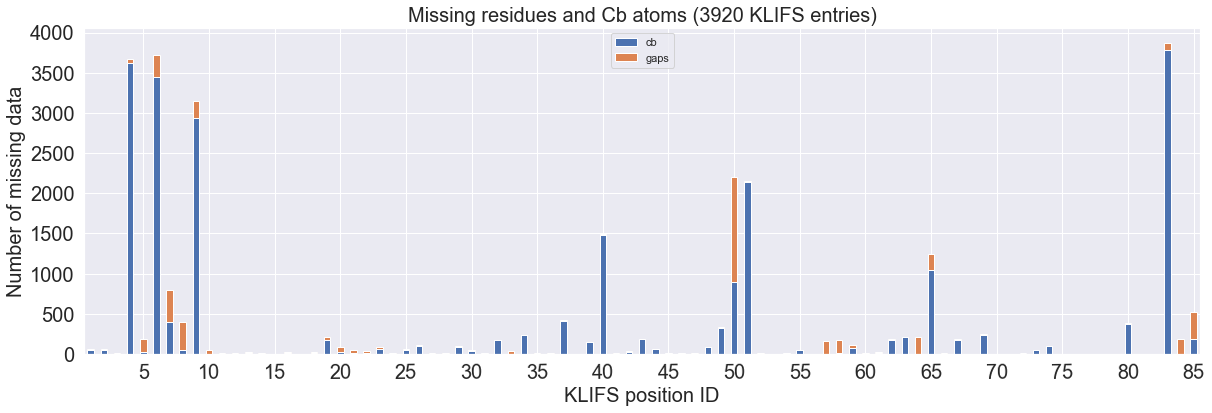

In [14]:
sco_stats.plot_missing_residues_ca_cb(path_to_results)

## SCO angle distribution

In [15]:
sco_stats.data

,klifs_id,residue_id,residue_name,ca,cb,com,sco,klifs_code
0,1,50,GLU,"<Vector -3.20, -23.46, -71.05>","<Vector -2.63, -22.05, -70.79>","<Vector -2.21, -22.21, -70.68>",94.16,HUMAN/AAK1_4wsq_altA_chainB
1,2,51,VAL,"<Vector -5.75, -22.67, -73.74>","<Vector -7.30, -22.87, -73.72>","<Vector -6.41, -22.39, -73.68>",21.29,HUMAN/AAK1_4wsq_altA_chainB
2,3,52,LEU,"<Vector -4.47, -19.59, -75.71>","<Vector -3.26, -19.64, -76.63>","<Vector -3.57, -19.55, -75.95>",27.98,HUMAN/AAK1_4wsq_altA_chainB
3,4,53,ALA,"<Vector -7.51, -18.97, -77.92>","<Vector -7.14, -17.87, -78.92>","<Vector -7.42, -19.51, -78.32>",22.51,HUMAN/AAK1_4wsq_altA_chainB
4,5,54,GLU,"<Vector -10.51, -20.69, -79.50>","<Vector -11.48, -21.24, -78.46>","<Vector -11.07, -20.30, -79.60>",25.87,HUMAN/AAK1_4wsq_altA_chainB
5,6,55,GLY,"<Vector -11.23, -19.12, -82.91>",None,"<Vector -10.73, -19.69, -83.41>",NaN,HUMAN/AAK1_4wsq_altA_chainB
6,7,56,GLY,"<Vector -12.19, -20.33, -86.39>",None,"<Vector -12.05, -21.11, -86.37>",NaN,HUMAN/AAK1_4wsq_altA_chainB
7,8,57,PHE,"<Vector -13.17, -23.98, -85.73>","<Vector -13.68, -24.45, -87.10>","<Vector -14.62, -23.75, -86.97>",89.28,HUMAN/AAK1_4wsq_altA_chainB
8,9,58,ALA,"<Vector -9.74, -24.57, -84.19>","<Vector -8.56, -24.24, -85.11>","<Vector -9.75, -23.97, -83.84>",23.05,HUMAN/AAK1_4wsq_altA_chainB
9,10,59,ILE,"<Vector -8.25, -24.25, -80.71>","<Vector -8.73, -25.11, -79.51>","<Vector -8.47, -24.92, -80.05>",16.58,HUMAN/AAK1_4wsq_altA_chainB


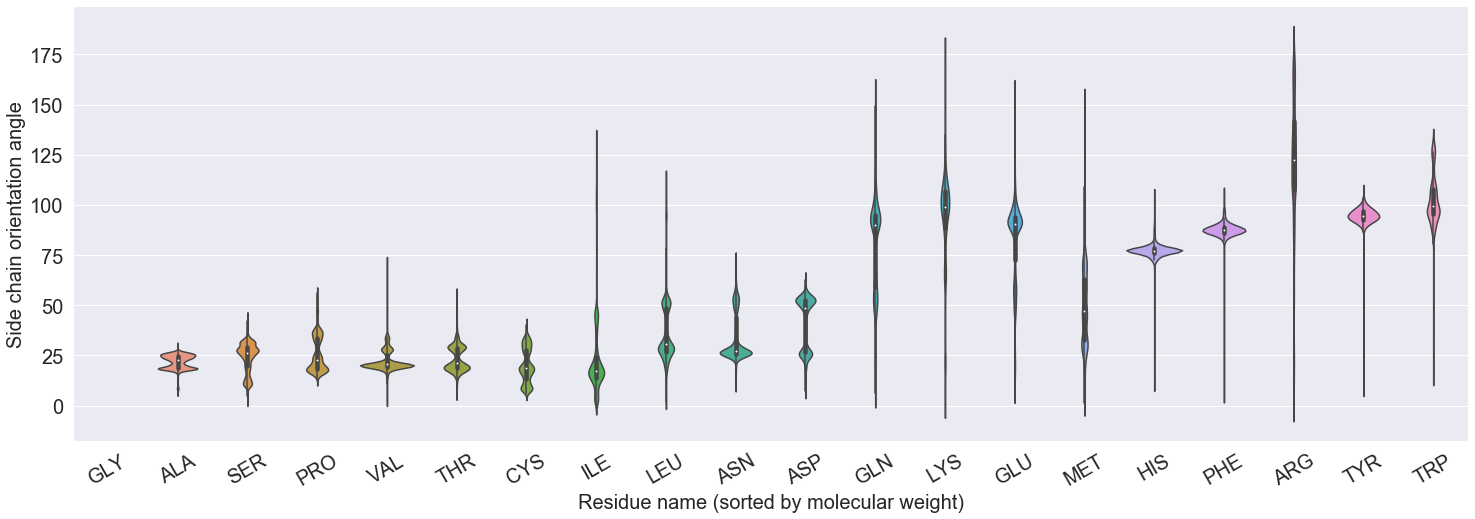

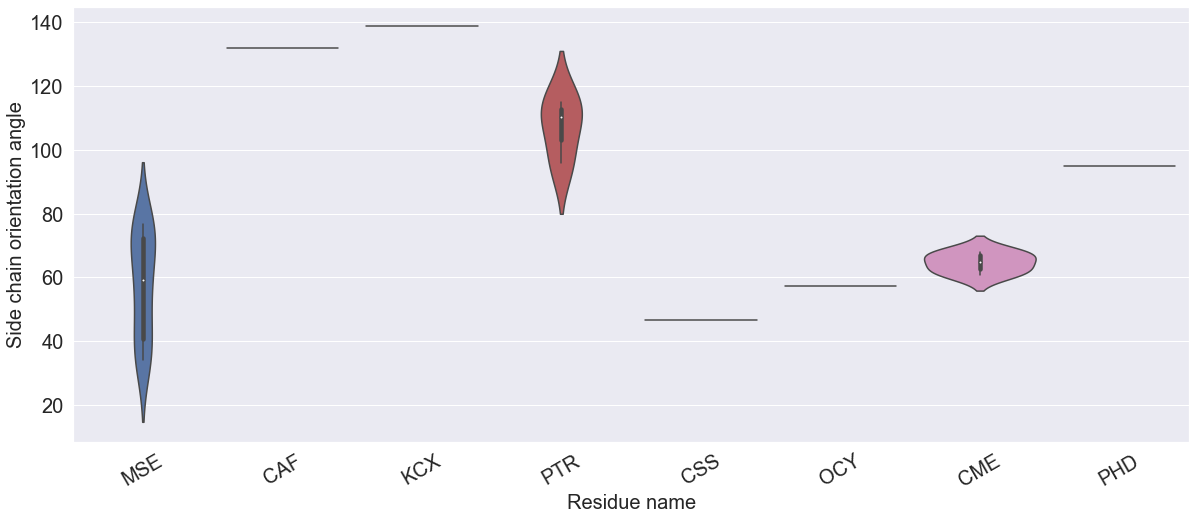

In [16]:
sco_stats.plot_side_chain_orientation_distribution(path_to_results, kind='violin')

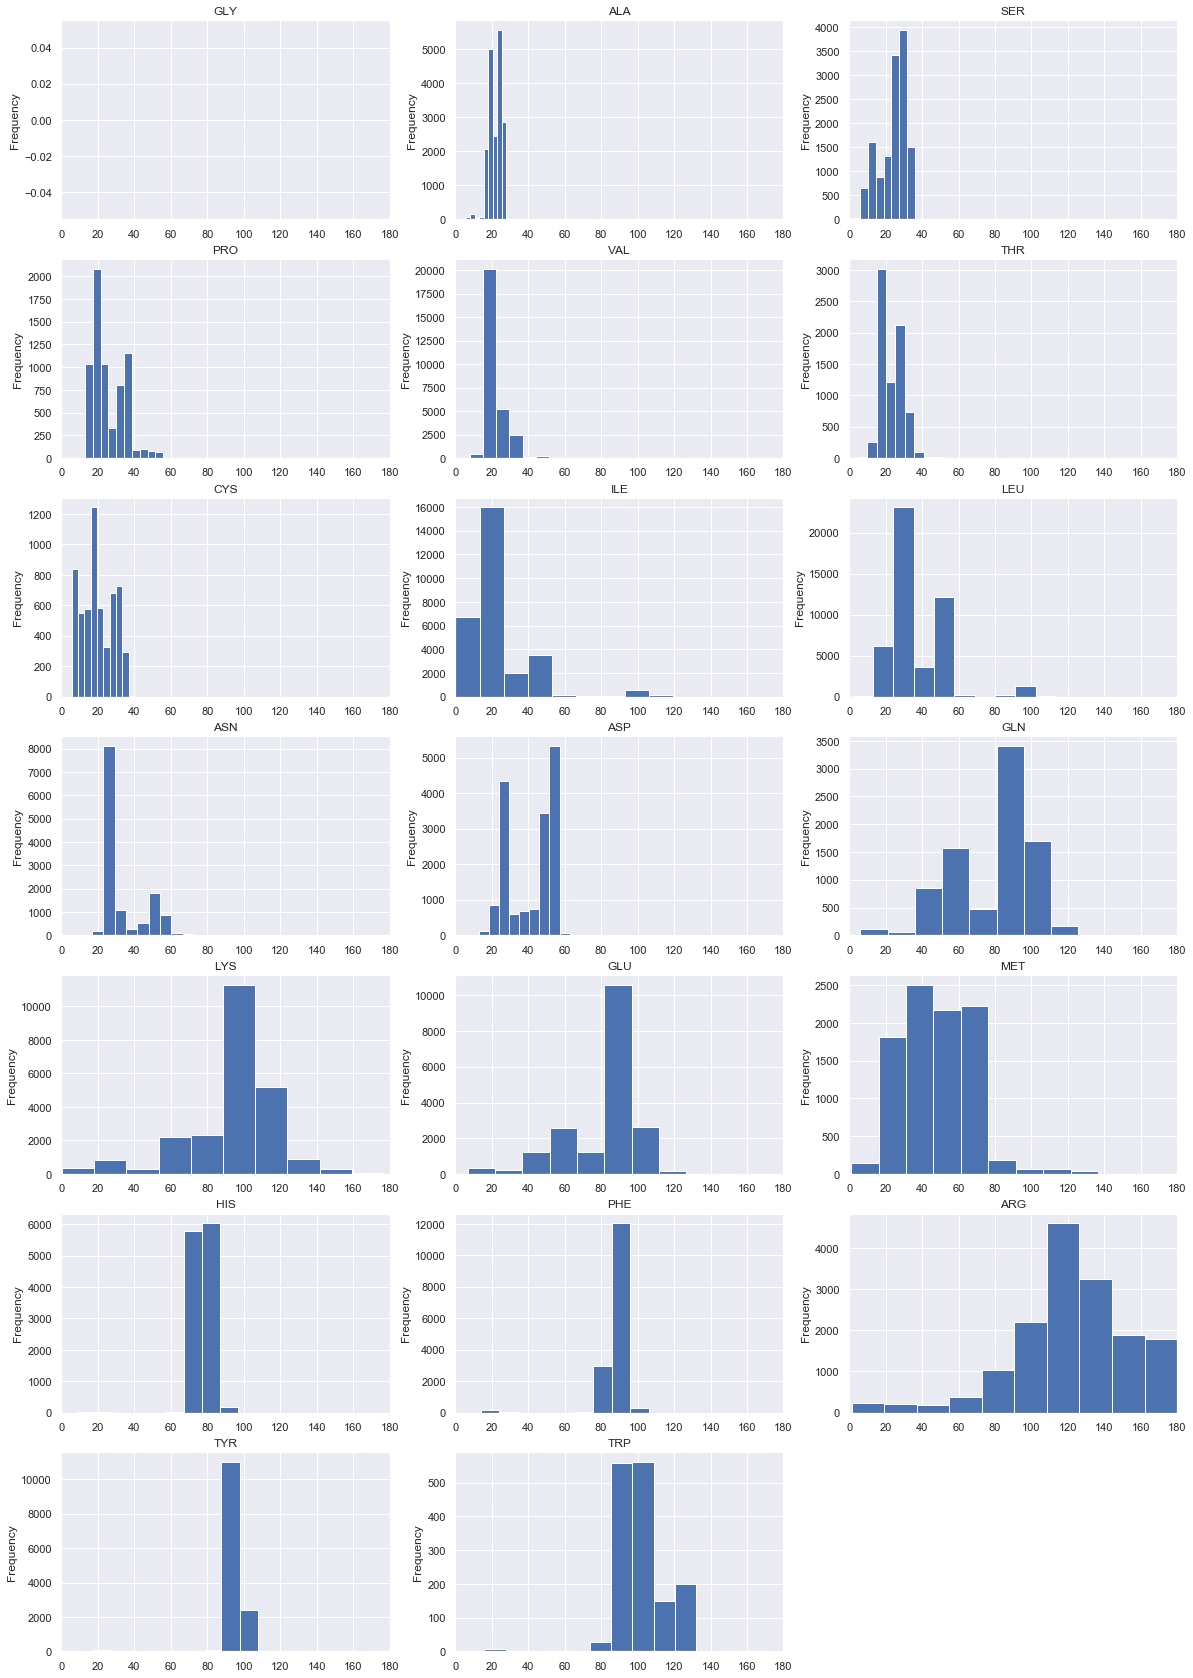

In [17]:
sco_stats.plot_side_chain_orientation_distribution(path_to_results, kind='histograms')